# Segmentation

_Tiffany Wang 260684152_

### 1.1 K-means clustering and Expectation Maximization

In [24]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import math

In [83]:
def plot_figs(imgs, title=None, max_col=4):
    n = len(imgs)
    sets = max(n // max_col, 1)
    for s in range(sets):
        start = s * 8
        subset = imgs[start:min(start+8, n)]
        nb_rows = 2 if len(subset) > 4 else 1
        subplot = "{}{}".format(nb_rows, max_col)
        plt.figure(figsize=(20, 4 * nb_rows))
        for i in range(len(subset)):
            plt.subplot(int("{}{}".format(subplot, i+1)))
            if title is not None: 
                plt.title('{} {}'.format(title, start + i + 1))
            plt.axis('off')
            plt.imshow(imgs[start + i].astype(np.uint8))
    plt.show()

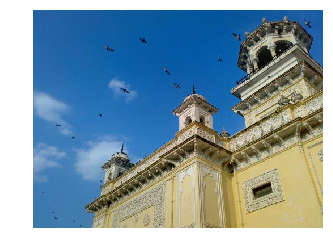

In [26]:
# Read 'home.jpg' picture in RGB.
home = cv2.imread('home.jpg')
home = cv2.cvtColor(home, cv2.COLOR_BGR2RGB)
plt.imshow(home), plt.axis('off')
plt.show()

###### Implement K-means clustering algorithm using only the numpy library. You can use opencv and matplotlib libraries only to read and display images but not for clustering. Apply k-means to the provided image with K=2 and K=3. Display the resulting segmented images for 10 iterations in both cases.

In [51]:
def k_means(img, k, iter=10):
    h, w, ch = img.shape
    img = img.astype(np.float64)
    centers = np.random.random_sample((k, ch)) * 255.0
    evol = []
    for it in range(iter):
        dists = np.array([img - c for c in centers])
        dists = np.linalg.norm(dists, axis=-1)
        clusters = np.argmin(dists, axis=0)
        evol.append(clusters)
        new_c = np.empty(shape=(k,ch))
        for c in range(k):
            np.mean(img[clusters == c], axis=0, out=new_c[c])
        centers = new_c

    plot_figs(evol, "iteration")

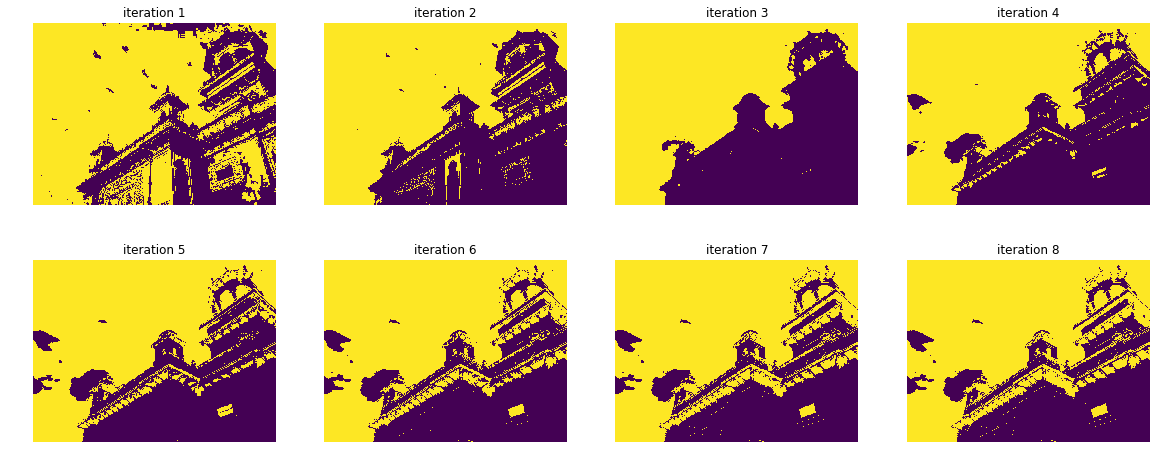

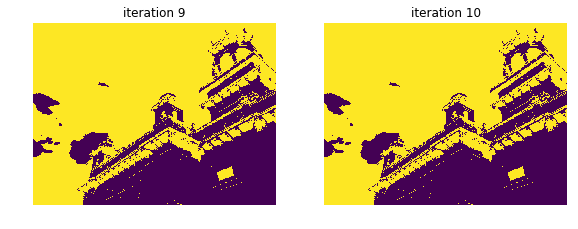

In [52]:
k_means(home, 2)

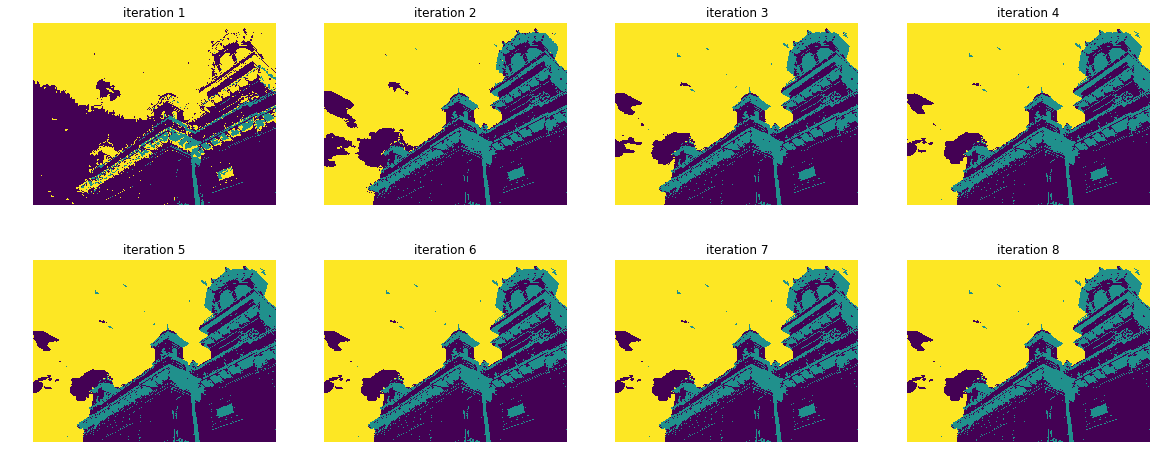

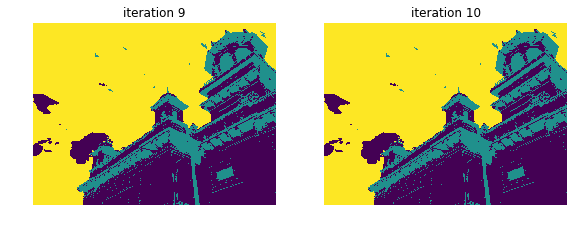

In [29]:
k_means(home, 3)

 ###### Implement the EM algorithm using only the numpy library. You can use opencv and matplotlib libraries only to read and display images. Apply it to the given image with 2 and 3 Gaussian components. Display the resulting segmented images for 10 iterations in both cases.

In [103]:
def gauss(x, mu, std):
    return np.linalg.norm(math.e**(-0.5 * np.power((x-mu)/std, 2)) / (math.sqrt(2*math.pi) * std), axis=-1)

def em(img, k, iter=10):
    h, w, ch = img.shape
    mus = np.random.random((k, ch)) * 255.0
    probs = np.full((k), (1.0 / k))
    std = np.full((k, ch), (255.0 / k))
    evol = []
    for it in range(iter):
        print("iteration ", it)
        print("mus: \n", mus)
        print("std: \n", std)
        print("probs: \n", probs)
        
        # E-step
        exp = np.empty(shape=(h, w, k))
        for i in range(h):
            for j in range(w): 
                exp[i][j] = gauss(img[i][j], mus, std)
        
        denom = np.sum(exp * probs, axis=-1)
        denom = denom.reshape((h, w, 1))
        exp = exp / denom
        
        #draw clusters
        clusters = np.argmax(exp, axis=-1)
        evol.append(clusters)
        
        #M-step 
        for c in range(k): 
            e = 0
            for i in range(h):
                for j in range(w): 
                    e += exp[i, j, c] * img[i, j]
            mus[c] = e / np.sum(exp[:,:,c])
            curr = img[clusters==c]
            std[c] = np.sqrt(np.var(curr, axis=0))
            probs[c] = np.size(curr) / np.size(img)
            
    plot_figs(evol)

iteration  0
mus: 
 [[ 34.12651644 166.73540044  32.79201132]
 [204.09506364 241.55032059  54.67062687]]
std: 
 [[127.5 127.5 127.5]
 [127.5 127.5 127.5]]
probs: 
 [0.5 0.5]
iteration  1
mus: 
 [[ 83.49915384 119.74410157 142.31158918]
 [101.33963145 128.82572029 139.95380014]]
std: 
 [[38.18110282 25.50435    53.13657498]
 [22.02428503 19.68157689 30.09631706]]
probs: 
 [0.70236206 0.29763794]
iteration  2
mus: 
 [[ 86.72577366 120.56001138 140.31322444]
 [102.30792531 131.12995754 143.27047341]]
std: 
 [[49.72221286 37.65796968 55.10979304]
 [67.38937791 38.13372095 41.71052174]]
probs: 
 [0.38520304 0.61479696]
iteration  3
mus: 
 [[ 86.71069657 120.05261163 139.23501231]
 [ 94.62687369 126.22602497 142.47546779]]
std: 
 [[34.68201765 26.63626213 58.84043203]
 [80.8060666  42.9412139  29.8612517 ]]
probs: 
 [0.52700297 0.47299703]
iteration  4
mus: 
 [[ 86.08250644 120.02113234 140.20810829]
 [ 97.66743024 128.09455769 142.37117724]]
std: 
 [[43.51754722 29.00621972 58.46668897]
 [8

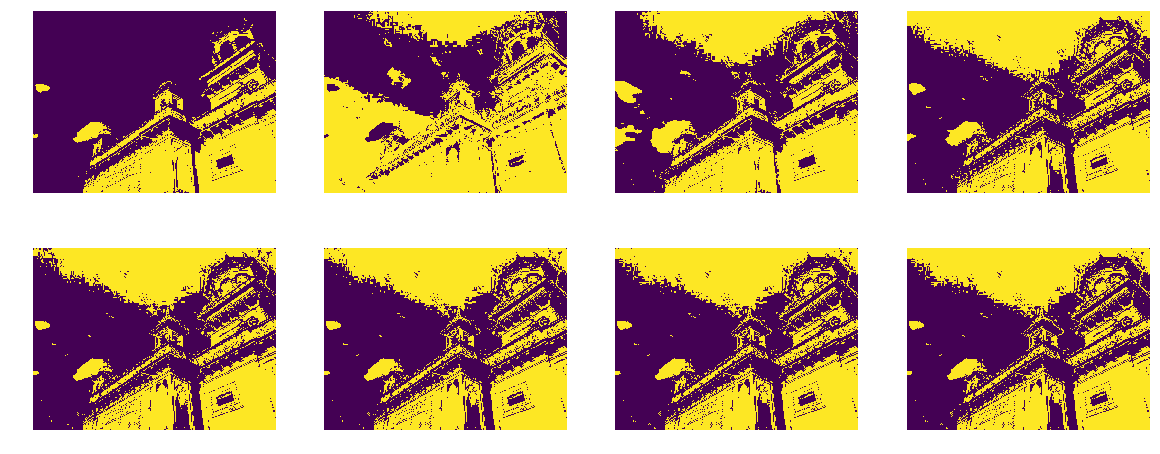

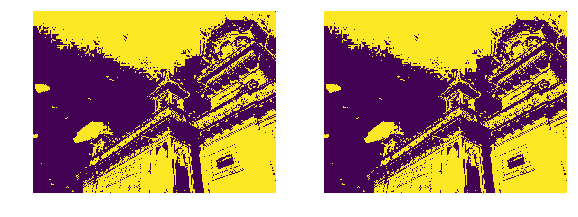

In [104]:
em(home, 2, 10)

iteration  0
mus: 
 [[ 51.99668595 218.91325153   7.76958514]
 [226.09402844 107.4212156  179.9013089 ]
 [237.50978813 156.61892521  35.27138409]]
std: 
 [[85. 85. 85.]
 [85. 85. 85.]
 [85. 85. 85.]]
probs: 
 [0.33333333 0.33333333 0.33333333]
iteration  1
mus: 
 [[ 85.98717587 119.26800915 138.47551052]
 [ 88.51461121 124.75020182 146.83666306]
 [101.07918433 127.36937678 137.01074531]]
std: 
 [[26.69694354 23.42262444 23.28659796]
 [72.00869275 37.58968294 21.90003266]
 [37.82429424 34.41668631 23.35702224]]
probs: 
 [0.09983317 0.7486674  0.15149943]
iteration  2
mus: 
 [[ 89.90273488 121.45264834 137.9904656 ]
 [ 90.44771089 123.66515153 142.28916439]
 [ 98.8673344  126.77981687 138.33256878]]
std: 
 [[34.26508297 22.00670424 58.34411213]
 [84.370281   51.57356166 36.70054005]
 [35.46599476 22.22635293 33.19910734]]
probs: 
 [0.42683919 0.37442017 0.19874064]
iteration  3
mus: 
 [[ 86.01247878 120.29361684 140.85724232]
 [ 95.53626801 126.26173277 141.15012582]
 [ 96.25136198 127.0

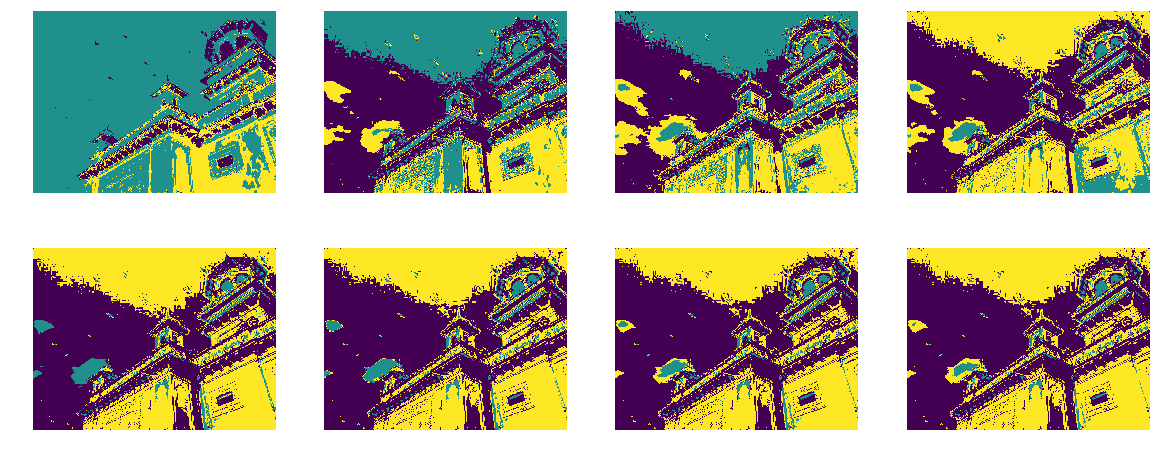

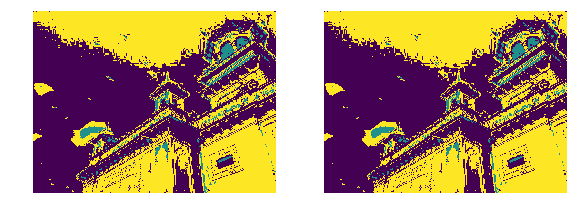

In [105]:
em(home, 3, 10)